In [549]:
import pandas as pd
import numpy as np
import plotly.express as px

# Data Cleaning
We will now clean the data we scraped from Tagvenue. 

**Important Note!** -> if re-running the script after scraping new data, you must ensure the 'price_type' column contains the combined prices types 'hire fee + min. spend' and 'hire fee + per person' **only**. If there are new combined prices or they no longer have the exact same wording, then you need to check the price cleaning section and make sure it is still compatible. 

Jump to [here](#pricing_strings) to see the unique values of *price_type*

Jump to [here](#pricing_clean) to see the functions that may be incompatible with changes to *price_type*

## Setup

In [550]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 0

## Importing Data
Below we import the general venue data and the prices data as dataframes. Metadata for both tables can be found in the repo Readme. 

In [551]:
venues = pd.read_csv('../data/raw_scraped_data/tag_venue_space_data_31-Jul-22.csv')
prices = pd.read_csv('../data/raw_scraped_data/tag_venue_space_prices_31-Jul-22.csv')

## Cleaning Prices Data
### Overview
We will start by cleaning the prices data which is previewed below: 

In [552]:
prices.head()

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,price,price_type
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Monday,Per hour,6:00 –,0:00,£360,hire fee per hour
1,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Tuesday,Per hour,6:00 –,0:00,£360,hire fee per hour
2,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Wednesday,Per hour,6:00 –,0:00,£360,hire fee per hour
3,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Thursday,Per hour,6:00 –,0:00,£360,hire fee per hour
4,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Friday,Per hour,6:00 –,0:00,£360,hire fee per hour


In [553]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54662 entries, 0 to 54661
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   space_url       54662 non-null  object 
 1   venue_url       54662 non-null  object 
 2   venue_name      54662 non-null  object 
 3   space_name      54662 non-null  object 
 4   latitude        54662 non-null  float64
 5   longitude       54662 non-null  float64
 6   day_of_week     54662 non-null  object 
 7   pricing_period  54662 non-null  object 
 8   time_from       51736 non-null  object 
 9   time_to         51736 non-null  object 
 10  price           51736 non-null  object 
 11  price_type      51736 non-null  object 
dtypes: float64(2), object(10)
memory usage: 5.0+ MB


In [554]:
prices.describe(include = 'all')

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,price,price_type
count,54662,54662,54662,54662,54662.000000,54662.000000,54662,54662,51736,51736,51736,51736
unique,4761,1740,1736,3216,NaN,NaN,7,7,38,46,1118,6
top,https://www.tagvenue.com/rooms/london/19621/fi...,https://www.tagvenue.com/venues/london/44/30-e...,30 euston square,whole venue,NaN,NaN,Wednesday,Per day,9:00 –,17:00,£500,hire fee
freq,56,408,408,3133,NaN,NaN,8212,15727,11574,9309,2485,17770
mean,NaN,NaN,NaN,NaN,51.511276,-0.120040,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.028975,0.063452,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,51.326833,-0.443729,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,51.503983,-0.144529,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,51.513528,-0.122588,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,51.522738,-0.084337,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning URLs
Below we check the space_url and venue_url columns contain no spaces and all start with 'https:://www.tagvenue.com'

In [555]:
# Confirm that no rows contain a ' ' character, should return no rows  
prices[prices.space_url.str.contains(" ")]

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,price,price_type


In [556]:
# Confirm that no rows contain a ' ' character, should return no rows  
prices[prices.venue_url.str.contains(" ")]

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,price,price_type


In [557]:
# Confirm all rows start with 'https://www.tagvenue.com'
assert(prices.space_url.str.contains(r'^https://www.tagvenue.com')).all()

In [558]:
# Confirm all rows start with 'https://www.tagvenue.com'
assert(prices.venue_url.str.contains(r'^https://www.tagvenue.com')).all()

### Cleaning Venue and Space Names
Below we remove leading or trailing whitspace from the venue_name and space_name columns: 

In [559]:
prices.venue_name = prices.venue_name.str.strip()
prices.space_name = prices.space_name.str.strip()

### Cleaning Longitude and Latitude
Below we check that the latitude and longitude values are all within the max and min latitude and longitude values defined in our web scrape: 

In [560]:
# Max and min latitude and longiotude values from web scrape:
latitude_min = 51.326626 
latitude_max = 51.7297765
longitude_min = -0.446500003
longitude_max = 0.2190751

assert(prices.latitude.min() > latitude_min)
assert(prices.latitude.max() < latitude_max)
assert(prices.longitude.min() > longitude_min)
assert(prices.longitude.max() < longitude_max)

<a id='pricing_strings'></a>
### Cleaning Pricing Strings
Below we review all string values taken by each of the following columns: 
- day_of_week
- pricing_period
- price_type

In [561]:
prices.day_of_week.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [562]:
prices.pricing_period.unique()

array(['Per hour', 'Per day', 'closed', 'Per evening', 'Per session',
       'Per morning', 'Per afternoon'], dtype=object)

In [563]:
prices.price_type.unique()

array(['hire fee per hour', 'hire fee', 'per person', nan, 'min. spend',
       'hire fee + min. spend', 'hire fee + per person'], dtype=object)

**Observations:** 

All columns have a small number of tidy strings that don't require cleaning. The nan values in *price_type* were to be expected, that is the value if the space is closed on a particular day (if 'pricing_period' is 'closed'). 

We need to confirm that the nan values occur across the final four columns of the prices dataframe only when the pricing_period is set to 'closed'.   

In [564]:
# filter on rows with pricing_period = 'closed'
closed_rows = prices[(prices.pricing_period == 'closed')]
# Drops 'closed' rows from dataframe
dropped_closed_rows = prices.drop(closed_rows.index)
# Display all rows in dataframe with a nan value
dropped_closed_rows[dropped_closed_rows.isna().any(axis=1)]

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,price,price_type


We have shown that after removing rows with pricing_period set to 'closed' that there are no more nan values in the dataframe. Thus all the nan values correspond with a day the space is closed and thus all the nan values were to be expected. We will remove these rows in our prices dataframe. 

In [565]:
prices = dropped_closed_rows
prices = prices.reset_index(drop = True)

### Cleaning Time Form and To
Firstly, we will clean the time_from column to remove the trailing '-' strings 

In [566]:
# Remove '-' from time_from and any remaining whitespace
prices.time_from = prices.time_from.str.replace('–','').str.strip()

Now we will convert the time data into floats e.g. '5:30' becomes '5.5'. We decided this was the easiest way to manipulate and graph the times.  

In [567]:
# Convert time to datetime object
from_time = pd.to_datetime(prices['time_from'], format='%H:%M')
# Extract and combine hours and minutes data into decimal form. 
prices.time_from = from_time.dt.hour + from_time.dt.minute / 60 

to_time = pd.to_datetime(prices['time_to'], format='%H:%M')
prices.time_to = to_time.dt.hour + to_time.dt.minute / 60 

Finally, we will calculate the time period between the time_from and time_to columns (in hours). Note that in this calculation, we calculate *time_to* - *time_from*. This sometimes gives a negative answer due to midnight going back to 0 in a 24 hour clock e.g. if time_to = 0.0 (midnight) and time_from = 6.0 (6 am) then the subtraction gives us -6. To get the correct answer we add 24 e.g. this becomes 18.  

In [568]:
# subtract time_to and time_from
prices.insert(10, 'time_period', prices.time_to - prices.time_from)
# Where the answer was negative, add 24
prices['time_period'] = np.where(prices.time_period < 0, 
                                 prices.time_period + 24, 
                                 prices.time_period)

<a id='pricing_clean'></a>
### Cleaning Price and Price Type
We will now clean the price and price type columns. There are 2 complicated cases for price and price type. When Price type is equal to 'hire fee + min. spend' or 'hire fee + per person' then the price is recorded as '£price + £price' where each price corresponds to the prices types. An example is shown below: 

**price_type** -> 'hire fee + min. spend'

**price** -> '£300 + £400' 

In this example, the hire fee is £300 and the minimum spend is £400. For all other price_types, there is only a single price provided e.g. 'per person' price_type might have a price of '£50'. 

We wish to create a new column, 'total_price' that has the total price rather than 2 prices being added together. e.g. '£300 + £400' becomes '£700'. But we also want to preserve the individual costs of hire fee and minimum spend / per person. As such, we will also create 3 new columns that contain the individual contributions to total_price of hire fee, minimum spend and per person respectively. These columns will be null for all rows except those using either 'hire fee + min. spend' or 'hire fee + per person' as the price type.

Below we build the new columns and replace the 'price' column with 'total_price'. 

In [569]:
def split_cols(price, type_):
    """Return list of cleaned price data.  
    
    If the price is a combination of prices, it will calculate the total
    price and also return the individual contributions of rent price, per 
    person and min spend."""
    # remove '£' from prices
    price = price.replace('£','')
    # checks if this price contains a '+' 
    if '+' in price:
        # splits prices between '+' into list
        price_list = price.split('+')
        # splits price type between '+' into list
        type_list = type_.split('+')
        total_price = float(price_list[0]) + float(price_list[1])
        # first price is always rent price (format is
        # '£rent price + £per person OR min. spend')
        rent_price = float(price_list[0])
        # If type includes 'min. spend' then the second price is minimum spend 
        if 'min.spend' in type_:
            min_spend = float(price_list[1])
            per_person = np.nan
        # Otherewise the second price must be per person
        else: 
            min_spend = np.nan
            per_person = float(price_list[1])
        return [total_price, type_, rent_price, min_spend, per_person]
    # returns just type and price, leaving rest of list nan if the 
    # price is not combined   
    return [float(price), type_, np.nan, np.nan, np.nan]
    
# Apply split_cols to the price and price_type columns
cleaned_price_data = [split_cols(price, type_)for price, type_ 
                      in zip(prices.price, prices.price_type)]
# Create the new columns we want
cleaned_price_df = pd.DataFrame(cleaned_price_data, 
                                columns = ['total_price', 'price_type', 
                                           'rent_price_split', 
                                           'min_spend_split', 
                                           'per_person_split'])
# drops columns we dont want anymore
prices.drop(columns = ['price', 'price_type'], inplace = True)
# Add new columns to data
prices = prices.join(cleaned_price_df)
prices.head()

,space_url,venue_url,venue_name,space_name,latitude,longitude,day_of_week,pricing_period,time_from,time_to,time_period,total_price,price_type,rent_price_split,min_spend_split,per_person_split
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Monday,Per hour,6.0,0.0,18.0,360.0,hire fee per hour,NaN,NaN,NaN
1,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Tuesday,Per hour,6.0,0.0,18.0,360.0,hire fee per hour,NaN,NaN,NaN
2,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Wednesday,Per hour,6.0,0.0,18.0,360.0,hire fee per hour,NaN,NaN,NaN
3,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Thursday,Per hour,6.0,0.0,18.0,360.0,hire fee per hour,NaN,NaN,NaN
4,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,Friday,Per hour,6.0,0.0,18.0,360.0,hire fee per hour,NaN,NaN,NaN


## Cleaning General Venue Data
We will now clean the general venues data previewed below: 

In [570]:
venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4761 entries, 0 to 4760
Data columns (total 92 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   space_url                                          4761 non-null   object 
 1   venue_url                                          4761 non-null   object 
 2   venue_name                                         4761 non-null   object 
 3   space_name                                         4761 non-null   object 
 4   latitude                                           4761 non-null   float64
 5   longitude                                          4761 non-null   float64
 6   address                                            4761 non-null   object 
 7   nearest_tube_station                               4425 non-null   object 
 8   max_seated                                         4761 non-null   int64  
 9   max_stan

In [571]:
venues.describe(include = 'all')

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,max_seated,max_standing,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),Halal menu,Kosher menu,Extensive vegan menu,...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
count,4761,4761,4761,4761,4761.000000,4761.000000,4761,4425,4761.000000,4761.000000,4761.000000,4761,4761,4761,3788.000000,3247.000000,1938.000000,2122.000000,1300.000000,1408.000000,1170.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,4761.000000,529,1155,1156,1156,4761.000000,4761.000000,469,3902,3902,3902,...,16,89,26,22,96,82,10,16,8,36,18,4,9,3,7,2,4761,4761,4761,4761,4761,4761,4761,4761,4761,4761,2667,4761,4761,4761,4761,4761,4761,4761,4761,1186,873,628,919,726
unique,4761,1740,1736,3216,NaN,NaN,1718,899,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,2,NaN,NaN,1,2,2,2,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,1,1,1,1,1
top,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/44/30-e...,30 euston square,whole venue,NaN,NaN,"30 Euston Square, Euston, London, NW1 2FB",Farringdon Station (300 yd),NaN,NaN,NaN,Venue offers catering,External catering not allowed,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,NaN,NaN,True,False,False,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,True,False,False,False,True,False,True,True,False,False,False,False,True,True,True,True,True
freq,1,24,24,329,NaN,NaN,24,42,NaN,NaN,NaN,3902,3605,4201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529,905,900,642,NaN,NaN,469,2008,2710,2077,...,16,89,26,22,96,82,10,16,8,36,18,4,9,3,7,2,4481,2706,2849,3274,2420,3574,3650,3390,3615,3881,2667,2889,3957,2889,2630,2990,3032,4063,3280,1186,873,628,919,726
mean,NaN,NaN,NaN,NaN,51.510889,-0.120217,NaN,NaN,76.337114,110.963663,203.426171,NaN,NaN,NaN,139.466209,79.027410,112.957172,24.831291,56.350769,70.993608,35.589744,0.187986,0.242596,0.757404,0.242806,0.757194,0.760134,0.239866,0.265700,0.734300,NaN,NaN,NaN,NaN,0.580130,0.190506,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [572]:
venues.head()

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,max_seated,max_standing,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),Halal menu,Kosher menu,Extensive vegan menu,...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,"St Mary Overie Dock, Cathedral Street, London,...",London Bridge Station (350 yd),65,120,129,Venue doesn’t offer catering,External catering allowed,False,120.0,60.0,30.0,30.0,65.0,NaN,NaN,0,1,0,1,0,0,1,0,1,True,True,False,False,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,False,True,False,NaN,NaN,NaN,NaN,NaN
1,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,"Mecklenburgh Square, London House, London, WC1...",Russell Square Station (600 yd),120,120,135,Venue offers catering,External catering not allowed,False,120.0,NaN,120.0,35.0,35.0,60.0,35.0,0,1,0,0,1,1,0,0,1,NaN,False,NaN,NaN,0.0,0.0,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,NaN,NaN,NaN,NaN,NaN
2,https://www.tagvenue.com/rooms/london/1044/gra...,https://www.tagvenue.com/venues/london/410/gra...,gracepoint,whole building,51.540573,-0.096280,"161-169 Essex Road, Islington, London, N1 2SN",Highbury & Islington Station (900 yd),1160,0,1561,Venue offers catering,External catering not allowed,False,NaN,NaN,1160.0,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
3,https://www.tagvenue.com/rooms/london/4056/aqu...,https://www.tagvenue.com/venues/london/1635/aq...,aquilla health and fitness,studio,51.495765,-0.170124,"11 Thurloe Place, London, SW7 2RS",South Kensington Station (400 yd),0,12,35,Venue doesn’t offer catering,External catering not allowed,False,12.0,NaN,NaN,NaN,

### Cleaning Address and Nearest Tube Station
We are not going to clean the space_url, venue_url, venue_name, space_name or latitude and longitude values because we already checked these values in the prices dataframe. Ideally we should repeat those cleaning steps here just in case, but in the interests of time saving we will forgo these checks. 

We reviewed the address column and believe that the only useful information in the address would be the postcode, which could be turned into latitude and longitude values. Since we already have latitude and longitude values, we probably dont need the address information. As such, we won't clean the 'address' column, but will keep it in the data to help distinguishing different venues when we are exploring the data (e.g. if we find some strange outliers or invalid data and want to cross reference). 

The 'nearest_tube_station' column contains the name of the nearest tube station followed by the distance in yards that the venue is from that station. An example is **London Bridge Station (400 yd)**. We will split this into 2 separate columns, nearest_tube_station and tube_distance. 

Below, we split the nearest_tube_station column using the '(' as the separator. We will split the data into 3 columns, as defined below: 

|Column|Data Stored|
|---|---|
|nearest_tube_station|Name of nearest tube station to venue|
|tube_distance|Distance in yards from venue to nearest tube station| 
|overflow|In cases where the tube station name contains parenthesis e.g. **Kensignton (Olympia) (400 yd)** then it will be split into 3 columns, the first half of the name will be in nearest_tube_station, the second half of the name will be in tube_distance and the distance will be in 'overflow'. For the majority of cases, overflow will be null|

As detailed in the table, the 'overflow' column will be used to deal with special cases where tube station name contains parenthesis e.g. **Kensignton (Olympia) (400 yd)**. We will fix the data alignment in these cases later.  


In [573]:
# Insert new columns next to 'nearest_tube_station' that will store the 
# nearest_tube_station data after it is split into separate columns.
# The tube_distance column will contain the distance data. 
venues.insert(8,'tube_distance', np.nan)
# The 'overflow' column will store the distance when the tube station name
# contains extra '(' that will need to be fixed
venues.insert(9,'overflow', np.nan)
columns = ['nearest_tube_station', 'tube_distance', 'overflow']
venues[columns] = venues.nearest_tube_station.str.split('(', expand = True)

venues[columns].head()

,nearest_tube_station,tube_distance,overflow
0,London Bridge Station,350 yd),None
1,Russell Square Station,600 yd),None
2,Highbury & Islington Station,900 yd),None
3,South Kensington Station,400 yd),None
4,Poplar Station,250 yd),None


Below we filter on the rows where overflow is non-null i.e. where the tube station name contained parenthesis '(' that we will need to fix. 

In [574]:
# Filter on rows that are non-null in 'overflow' 
non_null_overflow = venues[~venues['overflow'].isnull()]
# Store the index of these rows
index = non_null_overflow.index

non_null_overflow[columns]

,nearest_tube_station,tube_distance,overflow
645,Kensington,Olympia) Station,600 yd)
765,Hammersmith,D & P) Station,200 yd)
910,Kensington,Olympia) Station,600 yd)
1336,Hammersmith,D & P) Station,200 yd)
1464,Hammersmith,D & P) Station,200 yd)
2033,Hammersmith,D & P) Station,200 yd)
2291,Hammersmith,D & P) Station,800 yd)
3147,Hammersmith,D & P) Station,200 yd)
3503,Hammersmith,D & P) Station,350 yd)
3728,Kensington,Olympia) Station,400 yd)


We will fix these rows by combining the data 'from nearest_tube_station' and 'tube_distance' into a single name and will shift the distance data from 'overflow' into 'tube_distance' 

In [575]:
# Amend 'nearest_tube_station' to be a combination of the 
# 'nearest_tube_station' and 'tube_distance' columns, with a '(' between. 
venues.loc[index, 'nearest_tube_station'] = (
    non_null_overflow['nearest_tube_station'] 
    + '(' 
    + non_null_overflow['tube_distance']
)
# Amend 'tube_distance'to have the values in 'overflow' 
venues.loc[index, 'tube_distance'] = non_null_overflow['overflow']

venues.loc[index, columns]

,nearest_tube_station,tube_distance,overflow
645,Kensington (Olympia) Station,600 yd),600 yd)
765,Hammersmith (D & P) Station,200 yd),200 yd)
910,Kensington (Olympia) Station,600 yd),600 yd)
1336,Hammersmith (D & P) Station,200 yd),200 yd)
1464,Hammersmith (D & P) Station,200 yd),200 yd)
2033,Hammersmith (D & P) Station,200 yd),200 yd)
2291,Hammersmith (D & P) Station,800 yd),800 yd)
3147,Hammersmith (D & P) Station,200 yd),200 yd)
3503,Hammersmith (D & P) Station,350 yd),350 yd)
3728,Kensington (Olympia) Station,400 yd),400 yd)


Finally, we clean the tube_distance and nearest_tube_station columns and drop the 'overflow' column. 

In [576]:
# remove the 'yd)' string from the distance
venues.tube_distance = venues.tube_distance.str.replace(' yd)', '', regex = False)
venues.tube_distance = venues.tube_distance.str.strip()
# Transform to numeric data type
venues.tube_distance = pd.to_numeric(venues.tube_distance)
# replace nearest_tube_station column data
venues['nearest_tube_station'] = venues['nearest_tube_station'].str.strip()
# Drop overflow column
venues.drop(axis = 1, columns = 'overflow', inplace = True)

### Cleaning Max Seated / Standand and Area
We can check the venues.info() cell above and see that the columns max_seated, max_standing and area_in_m2 are all of type int64 and have no null values, meaning they all contain integer values as expected. 

We will quickly review their max and min values to check that the numbers look reasonable. 

In [577]:
venues[['max_seated', 'max_standing', 'area_in_m2']].max()

max_seated       4000
max_standing     4000
area_in_m2      34100
dtype: int64

In [578]:
venues[['max_seated', 'max_standing', 'area_in_m2']].min()

max_seated      0
max_standing    0
area_in_m2      0
dtype: int64

**Observations:**
- The maximum values all look reasonable, they are positive and realistic. They may be much larger than typical venue sizes and thus could be treated as outliers later on, but we can see no obvious reason to doubt their validity.   
- The minimum seated and standing are reasonable i.e. 0 but not negative, but the minimum area of 0 is impossible, obviously a venue should have a non-zero area. 
- It is worth checking that the max_seated and max_standing columns are never both zero at the same time. 

We will first investigate the zero area rows. They are shown below. 

In [579]:
venues[venues.area_in_m2 == 0]

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,tube_distance,max_seated,max_standing,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),Halal menu,Kosher menu,...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
976,https://www.tagvenue.com/rooms/london/22296/pl...,https://www.tagvenue.com/venues/london/9920/pl...,platform,multiplayer booth,51.522018,-0.086008,"2b Worship St, Finsbury, London, EC2A 2AH",Old Street Station,500.0,6,0,0,Venue offers catering,External catering not allowed,False,NaN,6.0,NaN,NaN,NaN,6.0,NaN,0,0,1,0,1,1,0,0,1,True,NaN,NaN,NaN,0.0,0.0,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,True,False,False,True,False,False,NaN,True,True,True,True,False,False,False,True,True,True,True,NaN,NaN
3267,https://www.tagvenue.com/rooms/london/4578/lon...,https://www.tagvenue.com/venues/london/1822/lo...,london party pub crawl,hen party pink package,51.509697,-0.132545,"Haymarket, 29, London, SW1Y 4SP",Piccadilly Circus Station,150.0,0,60,0,Venue doesn’t offer catering,External catering not allowed,False,60.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,0,1,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,NaN,NaN,NaN,NaN,NaN
4637,https://www.tagvenue.com/rooms/london/417/conw...,https://www.tagvenue.com/venues/london/186/con...,conway hall,the library,51.519792,-0.118337,"25 Red Lion Square, London, WC1R 4RL",Holborn Station,350.0,60,40,0,Venue offers catering,External catering not allowed,False,40.0,NaN,60.0,16.0,60.0,NaN,16.0,0,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,NaN,NaN,NaN,NaN,NaN


Upon investigating, it turns out one of the venues was actually a party package going to various venues, and thus is not actually a venue at all. The other 2 spaces had errors in the area provided i.e. were incorrectly set to 0. We will drop the non-venue row (3267).

In [580]:
venues.drop(3267, inplace = True)
venues.reset_index(drop = True)

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,tube_distance,max_seated,max_standing,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),Halal menu,Kosher menu,...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,"St Mary Overie Dock, Cathedral Street, London,...",London Bridge Station,350.0,65,120,129,Venue doesn’t offer catering,External catering allowed,False,120.0,60.0,30.0,30.0,65.0,NaN,NaN,0,1,0,1,0,0,1,0,1,True,True,False,False,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,False,True,False,NaN,NaN,NaN,NaN,NaN
1,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,"Mecklenburgh Square, London House, London, WC1...",Russell Square Station,600.0,120,120,135,Venue offers catering,External catering not allowed,False,120.0,NaN,120.0,35.0,35.0,60.0,35.0,0,1,0,0,1,1,0,0,1,NaN,False,NaN,NaN,0.0,0.0,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,NaN,NaN,NaN,NaN,NaN
2,https://www.tagvenue.com/rooms/london/1044/gra...,https://www.tagvenue.com/venues/london/410/gra...,gracepoint,whole building,51.540573,-0.096280,"161-169 Essex Road, Islington, London, N1 2SN",Highbury & Islington Station,900.0,1160,0,1561,Venue offers catering,External catering not allowed,False,NaN,NaN,1160.0,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
3,https://www.tagvenue.com/rooms/london/4056/aqu...,https://www.tagvenue.com/venues/london/1635/aq...,aquilla health and fitness,studio,51.495765,-0.170124,"11 Thurloe Place, London, SW7 2RS",South Kensington Station,400.0,0,12,35,Venue doesn’t offer catering,External catering not allowed,False,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,1,1,0,NaN,

The above investigation identified a general issue with the areas reported by some venues. For example, a venue might have a maximum standing space for 250 and a reported area of 2 m2, which is obviously wrong. We wanted a way to identify these incorrectly reported areas. 

Firstly, we created a new column called 'max_seated_or_standing' which contained the maximum of either max_standing or max_seated. We would use this as a rough proxy for the expected size of the venue. 

In [581]:
max_seated_or_standing = np.where(venues.max_seated > venues.max_standing, 
                                  venues.max_seated, venues.max_standing)
venues.insert(11, 'max_seated_or_standing', max_seated_or_standing)

Initially, we tried to build a simple OLS regression model between 'max_seated_or_standing' and 'area_in_m2'. We hoped we could identify outliers from this model. The model is visualised below, it has a very low R2 value and is clearly a bad fit. 

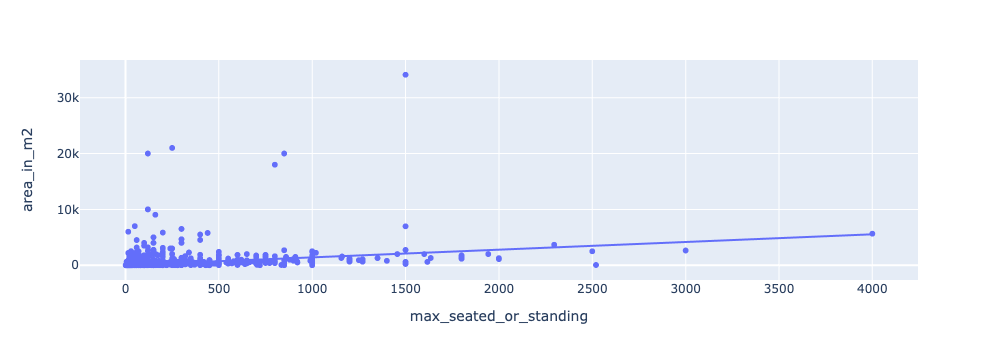

In [582]:
fig = px.scatter(venues, x="max_seated_or_standing", y="area_in_m2", trendline="ols")
fig.show()

As such, we changed strategies and instead created a new variable, min_area_per_person, which was the 'area_in_m2' divided by 'max_seated_or_standing', giving us the minimum area per person. 

We estimated that a reasonable minimum area per person was probably 0.5 -> that is 0.5 m2 per person. To test the validity of our estimate, we plotted a histogram and strip plot of min_area_per_person. We also calculated the mean, median and 8th quantile. 

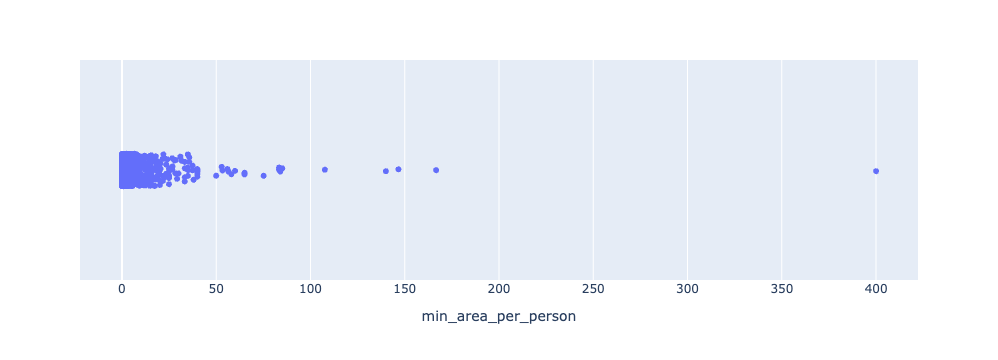

In [583]:
min_area_per_person = venues.area_in_m2 / venues.max_seated_or_standing
venues.insert(12, 'min_area_per_person', min_area_per_person)

fig = px.strip(venues, x = 'min_area_per_person')
fig.show()

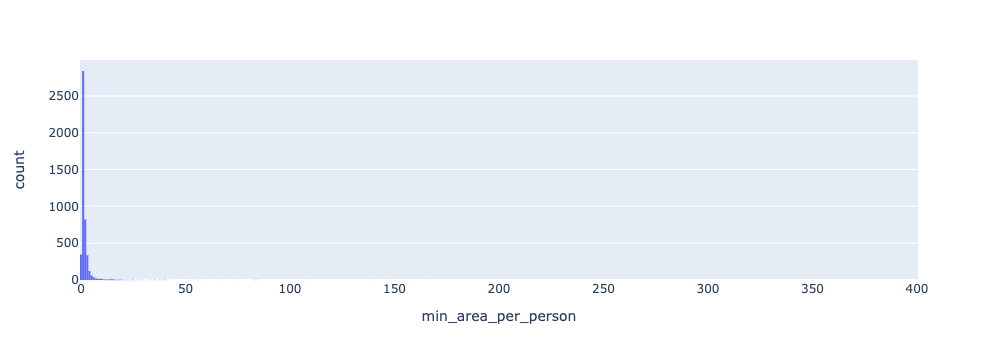

In [584]:
fig = px.histogram(venues, x = 'min_area_per_person')
fig.show()

In [585]:
venues.min_area_per_person.mean()

2.35211553205619

In [586]:
venues.min_area_per_person.median()

1.1

In [587]:
venues.min_area_per_person.quantile(0.08)

0.5

The distribution is approximately normal in shape (with very long tails, the plots above have been zoomed in). The median suggests a typical area per person of 1.1 and this is reflected in both the above plots. We can see that the histograms lowest bin goes between 0 and 0.5 and suggests that 0.5 or lower could be a reasonable cut off for abnormally low values, less than half the typical value and accounting for the lowest 8% of spaces.

We are going to assume that any min_area_per_person that is less than 0.5 is due to an incorrect area and we will define the area as null. 

In [588]:
# get index of rows with min_area_per person < 0.5
incorrect_area = venues[venues.min_area_per_person < 0.5].index
venues.loc[incorrect_area, ['area_in_m2', 'min_area_per_person']] = np.nan

Finally, we will check whether the max and min standing / seated are ever zero simultaneously. 

In [589]:
venues[venues.max_seated_or_standing == 0] 

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,tube_distance,max_seated,max_standing,max_seated_or_standing,min_area_per_person,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site


In [590]:
venues.head()

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,tube_distance,max_seated,max_standing,max_seated_or_standing,min_area_per_person,area_in_m2,catering_offered,external_catering_allowed,supervenue,Standing_max,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,Approved caterers only,BYO alcohol allowed,BYO alcohol not allowed,External catering allowed,External catering not allowed,In-house catering,No in-house catering,Venue doesn’t provide alcohol,Venue provides alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,"St Mary Overie Dock, Cathedral Street, London,...",London Bridge Station,350.0,65,120,120,1.075000,129.0,Venue doesn’t offer catering,External catering allowed,False,120.0,60.0,30.0,30.0,65.0,NaN,NaN,0,1,0,1,0,0,1,0,1,True,True,False,False,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,False,True,False,NaN,NaN,NaN,NaN,NaN
1,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,"Mecklenburgh Square, London House, London, WC1...",Russell Square Station,600.0,120,120,120,1.125000,135.0,Venue offers catering,External catering not allowed,False,120.0,NaN,120.0,35.0,35.0,60.0,35.0,0,1,0,0,1,1,0,0,1,NaN,False,NaN,NaN,0.0,0.0,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,NaN,NaN,NaN,NaN,NaN
2,https://www.tagvenue.com/rooms/london/1044/gra...,https://www.tagvenue.com/venues/london/410/gra...,gracepoint,whole building,51.540573,-0.096280,"161-169 Essex Road, Islington, London, N1 2SN",Highbury & Islington Station,900.0,1160,0,1160,1.345690,1561.0,Venue offers catering,External catering not allowed,False,NaN,NaN,1160.0,NaN,NaN,NaN,NaN,1,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
3,https://www.tagvenue.com/rooms/london/4056/aqu...,https://www.tagvenue.com/venues/london/1635/aq...,aquilla health and fitness,studio,51.495765,-0.170124,"11 Thurloe Place, London, SW7 2RS",South Kensington Station,400.0,0,12,12,2.916667,35.0,Venue doesn’t offer catering,External catering not allowed,False,1

### Cleaning Layout Section
Next we will clean the layout section - these are the columns like Theatre_max, Boardroom_max etc. which describe a room layout in the column name and have a value corresponding to the maximum number of people who can be accommodated with that layout. E.g. Boardroom_max might have a value of 40 meaning that if you set up the space as a boardroom, it can accommodate 40 people. 

Firstly, we will move the 'external_catering_allowed', 'catering_offered' and 'supervenue' columns to the right of the layout columns, because we think it makes more sense. 

In [591]:
external_catering_allowed = venues.pop('external_catering_allowed')
catering_offered = venues.pop('catering_offered')
supervenue = venues.pop('supervenue')

venues.insert(21, 'supervenue', supervenue)
venues.insert(22, 'external_catering_allowed', external_catering_allowed)
venues.insert(23, 'catering_offered', catering_offered)

Each layout column contains 2 bits of information: 
1. Is this layout available
2. If so, what is the max number of people

We want to split this info out into 2 separate columns, to make the data exploration a bit easier. To do this we will split each layout into 2 columns, a Bool column that defines whether the layout is available and a max capacity column that defines the maximum capacity. At present, if the layout is unavailable, its max capacity will be set to null. We will change this so that it is set to zero. Also note, the Standing_max column contains redundant data, all its info is already contained in the max_standing column, so we will drop this column and add a bool column for max_standing.  

In [592]:
# Drop redundant Standing_max column
venues.drop(axis = 1, columns = 'Standing_max', inplace = True)

# Create Bool columns for each layout, with True if non-null 
# or > 0 and False if 0 or null.  
standing = np.where(venues.max_standing > 0, True, False)
dining =  np.where(venues.Dining_max > 0, True, False)
theatre =  np.where(venues.Theatre_max > 0, True, False)
boardroom =  np.where(venues.Boardroom_max > 0, True, False)
classroom =  np.where(venues.Classroom_max > 0, True, False)
cabaret =  np.where(venues.Cabaret_max > 0, True, False)
u_shaped =  np.where(venues['U-Shaped_max'] > 0, True, False)

# Insert bool columns into venues
venues.insert(14, 'standing', standing)
venues.insert(15, 'dining', dining)
venues.insert(16, 'theatre', theatre)
venues.insert(17, 'boardroom', boardroom)
venues.insert(18, 'classroom', classroom)
venues.insert(19, 'cabaret', cabaret)
venues.insert(20, 'u_shaped', u_shaped)

# Fill nan values with 0 
venues.loc[:, 'Dining_max':'U-Shaped_max'] = (
    venues.loc[:, 'Dining_max':'U-Shaped_max'].fillna(0)
)

Finally, we will perform a quick check that the max_seated value is correct by calculating this value explicitly and comparing it with max_seated.  

In [593]:
max_seated_per_row = venues.loc[:, 'Dining_max':'U-Shaped_max'].max(axis=1)
assert(max_seated_per_row == venues.max_seated).all()

### Cleaning Remaining categorical and Bool Columns
The remaining columns are of the following forms:
- True / False Bool columns e.g. the 'supervenue' column is either True or False to indicate if this venue is a supervenue. 
- Binary 1 or 0 columns to indicate if something is available e.g. the column 'Wifi' has a 1 if wifi is available and a 0 if it is not. 
- Simple categorical columns (e.g. for external_catering_allowed there are 2 categories: 'external catering allowed' and 'external catering not allowed') 

As we will see, some of the Binary columns are mutually exclusive e.g. 'BYO alcohol not allowed' and 'BYO alcohol allowed' are effectively One Hot Encoded i.e. when one is 1, the other will be 0. Thus, we will combine these columns into a single categorical column (this will be easier to use in plotting during data exploration).  

In general, we will aim to make all these columns either categorical or Bool, i.e. we dont want any binary columns (1 or 0). Some of them will contain null values. We will try and remove these as well, as long as it makes sense to do so.  

#### Supervenue
We will start off by reviewing the  'supervenue' column. This is a simple True / False bool column and by looking at the venues.info() output (at top) you can easily see it contains no nan values and is of type bool meaning all the entries must be True or False. We will perform a quick second check, a value_count on the column: 

In [594]:
venues['supervenue'].value_counts()

False    4200
True      560
Name: supervenue, dtype: int64

The 'supervenue' column looks good. 

#### Catering
We will now review the various catering related columns. We have many different catering columns listed below: 

|column name|Description|Possible Values|
|---|---|---|
|external_catering_allowed|Indicates if any external caterer is allowed|<ul><li>External catering allowed</li><li>External catering not allowed</li></ul>|
|catering_offered|Indicates if the venue either has in-house catering or allows external catering from an approved list (cannot use any External caterer)|<ul><li>Venue offers catering</li><li>Venue doesn’t offer catering</li></ul>|
|Approved caterers only|Indicates if the venue allows external caterers from an approved list (cannot use any External caterer)|<ul><li>1</li><li>0</li></ul>|
|External catering not allowed|Indicates if any external caterer is **not** allowed (cannot use any External caterer)|<ul><li>1</li><li>0</li></ul>|
|External catering allowed|Indicates if any external caterer is allowed|<ul><li>1</li><li>0</li></ul>|
|In-house catering|Indicates if the venue has in-house catering available|<ul><li>1</li><li>0</li></ul>|
|No in-house catering|Indicates if the venue does **not** have in-house catering available|<ul><li>1</li><li>0</li></ul>|

It should be noted that the following pairs of columns are mutually exclusive i.e. if one is 1 then the other is 0: 
- **External catering not allowed** and **External catering allowed**
- **In-house catering** and **No in-house catering**

The easiest way to understand these columns is to perform value counts across similar columns to see all the unique permutations. We will start with the external venue columns:

In [595]:
venues[['external_catering_allowed', 'External catering not allowed', 
        'External catering allowed']].value_counts()

external_catering_allowed      External catering not allowed  External catering allowed
External catering not allowed  1                              0                            3604
External catering allowed      0                              1                            1156
dtype: int64

We can see that 'External catering not allowed'  and 'External catering allowed' are mutually exclusive (if one is 1, the other is 0) and that the data from these columns is already contained in the 'external_catering_allowed' column. That means we can drop 'External catering not allowed'  and 'External catering allowed' without losing any information. 

Below, we will perform a value count across the remaining catering columns (the ones not related to external catering): 

In [596]:
venues[['catering_offered', 
        'Approved caterers only', 'In-house catering', 
        'No in-house catering']].value_counts()

catering_offered              Approved caterers only  In-house catering  No in-house catering
Venue offers catering         0                       1                  0                       3007
Venue doesn’t offer catering  0                       0                  1                        858
Venue offers catering         1                       1                  0                        612
                                                      0                  1                        283
dtype: int64

From the above, we can interpret the 'catering_offered' column as follows: 
- It will have the value **'venue offers catering'** if either: 
  1. The venue has in-house catering **but doesn't** allow external vendors from an approved list
  2. The venue has in-house catering **and allows** external vendors from an approved list
  3. The venues does not have in-house catering **But does** allow external vendors from an approved list
- It will have the value **'Venue doesn’t offer catering'** if the venue does not have in-house cater **and doesn't** allow external vendors from an approved list

Basically, if food is available at the venue either through an approved external vendor list or through an in-house kitchen, 'catering_offered' will have the value 'venue offers catering'.

We can also see that 'In-house catering' and  'No in-house catering' are mutually exclusive. The 'catering_offered' column is formed from the 3 columns 'Approved caterers only', 'In-house catering' and 'No in-house catering'. It has effectively lost some information because you can't tell if it means the venue has in-house catering or an approved external list or both. As such, we can drop it and use the remaining 3 columns instead. We can also drop one of the 2 in-house catering columns because they are mutually exclusive hence one is redundant. 

To get the full unique permutations of all the catering information, we will perform a value counts across the 'external_catering_allowed', 'Approved caterers only' and 'In-house catering' columns: 

In [597]:
venues[['external_catering_allowed', 'In-house catering', 
        'Approved caterers only',]].value_counts()

external_catering_allowed      In-house catering  Approved caterers only
External catering not allowed  1                  0                         2536
External catering allowed      0                  0                          685
External catering not allowed  1                  1                          612
External catering allowed      1                  0                          471
External catering not allowed  0                  1                          283
                                                  0                          173
dtype: int64

These 3 columns combined provide all possible catering options for a venue, namely whether any External caterer can be used, whether an approved list of caterers is allowed (rather than any External caterer) and whether an in-house kitchen is available.  

We decided to combine all 3 columns together into a single categorical column called **'catering'**. The below table shows how each permutation of the 3 columns maps to the new **'catering'** column and provides a description of what each category means.   

|external_catering_allowed|In-house catering|Approved caterers only|catering|Description|
|:---:|:---:|:---:|:---:|---|
|External catering not allowed|1|0|Venue Catering Only|Must use venue's in-house chef.|
|External catering allowed|0|0|External Catering Only|Can use any external caterers to get food.| 
|External catering not allowed|1|1|Approved Caterers or Venue Catering|Must use approved list of external caterers or use venue's in-house chef.| 
|External catering allowed|1|0|External Catering + Venue Catering|Can either use any external caterers or use venue's in-house chef.| 
|External catering not allowed|0|1|Approved Caterers Only|Must use approved list of external caterers.| 
|External catering not allowed|0|0|No catering available|Cannot get food at venue.| 

In [598]:
# Define permutation condition for each category in new 'catering' column 
conditions = [venues.external_catering_allowed.eq('External catering not allowed') 
              & venues['In-house catering'].eq(1) 
              & venues['Approved caterers only'].eq(0),
              
              venues.external_catering_allowed.eq('External catering allowed') 
              & venues['In-house catering'].eq(0) 
              & venues['Approved caterers only'].eq(0),
              
              venues.external_catering_allowed.eq('External catering not allowed') 
              & venues['In-house catering'].eq(1) 
              & venues['Approved caterers only'].eq(1),
              
              venues.external_catering_allowed.eq('External catering allowed') 
              & venues['In-house catering'].eq(1) 
              & venues['Approved caterers only'].eq(0),
              
              venues.external_catering_allowed.eq('External catering not allowed') 
              & venues['In-house catering'].eq(0) 
              & venues['Approved caterers only'].eq(1),
              
              venues.external_catering_allowed.eq('External catering not allowed') 
              & venues['In-house catering'].eq(0) 
              & venues['Approved caterers only'].eq(0)
             ]
# Define category name corresponding to each condition above
choices = ['Venue Catering Only', 'External Catering Only', 
           'Approved Caterers or Venue Catering', 
           'External Catering + Venue Catering',
           'Approved Caterers Only', 'No catering available']

# Create new catering column based on permutation conditions
catering = np.select(conditions, choices)
# Add catering column to venues
venues.insert(28, 'catering', catering)
# Remove the old columns
venues.drop(axis = 1, columns = ['external_catering_allowed', 'catering_offered', 
                                 'Approved caterers only', 
                                 'External catering not allowed', 
                                 'External catering allowed', 
                                 'In-house catering', 
                                 'No in-house catering'], 
            inplace = True)              
# Preview value counts of new column
venues.catering.value_counts()

Venue Catering Only                    2536
External Catering Only                  685
Approved Caterers or Venue Catering     612
External Catering + Venue Catering      471
Approved Caterers Only                  283
No catering available                   173
Name: catering, dtype: int64

As the above value count shows, we have successfully condensed the information of the 3 columns 'external_catering_allowed', 'In-house catering' and 'Approved caterers only' into a single new column. 

#### BYO or Venue Provided Alcohol
We will now analyse the following pairs of mutually exclusive columns: 
- **BYO alcohol allowed** and **BYO alcohol not allowed**
- **Venue doesn’t provide alcohol** and **Venue provides alcohol**

We will first perform value counts on each pair to confirm they are mutually exclusive: 

In [599]:
venues[['BYO alcohol allowed', 'BYO alcohol not allowed']].value_counts()

BYO alcohol allowed  BYO alcohol not allowed
0                    1                          3605
1                    0                          1155
dtype: int64

In [600]:
venues[['Venue doesn’t provide alcohol', 'Venue provides alcohol']].value_counts()

Venue doesn’t provide alcohol  Venue provides alcohol
0                              1                         3495
1                              0                         1265
dtype: int64

We have confirmed they are mutually exclusive. We will now combine each pair into a single bool column, which will be a better format for plotting when exploring the data: 

In [601]:
byo_alcohol_allowed = np.where(venues['BYO alcohol allowed'] == 1, 
                               True, False)
venue_provides_alcohol = np.where(venues['Venue provides alcohol'] == 1, 
                                  True, False)

venues.insert(29, 'byo_alcohol_allowed', byo_alcohol_allowed)
venues.insert(30, 'venue_provides_alcohol', venue_provides_alcohol)

venues.drop(axis = 1, columns =['BYO alcohol allowed', 
                                'BYO alcohol not allowed', 
                                'Venue doesn’t provide alcohol', 
                                'Venue provides alcohol'], 
            inplace = True)

#### Alcohol Licence
- Confirm from scrape that this is indeed all alcohol licence info 
- make 2 columns, alcohol licence time (in a format that makes sense i.e. categorical OR Ordinal...probably categorical with 'No licence' as an option as well) and separate column 'extension available' which would have values extension availabel, unavailable or alcohol not available 
- OR make it ordinal with alcohol licnece True / False and time if true and extension available if true....then could do OHE combining all 3 i.e. Not avasilable, Available with extension at several times, available with no extension at various times....) 

- Note alcohol licences all are either True or Nan...

In [645]:
alcohol_licences = [column for column in venues.columns if 'Alcohol licence' in column]
alcohol_licences

['Alcohol licence until 23:00',
 'Alcohol licence until 23:00 (extension available)',
 'Alcohol licence until 1:30',
 'Alcohol licence until 1:00',
 'Alcohol licence until 0:00',
 'Alcohol licence until 1:00 (extension available)',
 'Alcohol licence until 5:00 (extension available)',
 'Alcohol licence until 3:00 (extension available)',
 'Alcohol licence until 0:00 (extension available)',
 'Alcohol licence until 2:00 (extension available)',
 'Alcohol licence until 22:30',
 'Alcohol licence until 22:00',
 'Alcohol licence until 2:00',
 'Alcohol licence until 22:30 (extension available)',
 'Alcohol licence until 3:00',
 'Alcohol licence until 0:30 (extension available)',
 'Alcohol licence until 4:00',
 'Alcohol licence until 23:30',
 'Alcohol licence until 23:30 (extension available)',
 'Alcohol licence until 21:30',
 'Alcohol licence until 4:00 (extension available)',
 'Alcohol licence until 2:30',
 'Alcohol licence until 0:30',
 'Alcohol licence until 22:00 (extension available)',
 'Alc

In [647]:
(venues[alcohol_licences] == False).any(axis = 0)

Alcohol licence until 23:00                          False
Alcohol licence until 23:00 (extension available)    False
Alcohol licence until 1:30                           False
Alcohol licence until 1:00                           False
Alcohol licence until 0:00                           False
Alcohol licence until 1:00 (extension available)     False
Alcohol licence until 5:00 (extension available)     False
Alcohol licence until 3:00 (extension available)     False
Alcohol licence until 0:00 (extension available)     False
Alcohol licence until 2:00 (extension available)     False
Alcohol licence until 22:30                          False
Alcohol licence until 22:00                          False
Alcohol licence until 2:00                           False
Alcohol licence until 22:30 (extension available)    False
Alcohol licence until 3:00                           False
Alcohol licence until 0:30 (extension available)     False
Alcohol licence until 4:00                           Fal

In [ ]:
venues[alcohol_licences].value_counts(dropna = False)

In [602]:
venues.head()

,space_url,venue_url,venue_name,space_name,latitude,longitude,address,nearest_tube_station,tube_distance,max_seated,max_standing,max_seated_or_standing,min_area_per_person,area_in_m2,standing,dining,theatre,boardroom,classroom,cabaret,u_shaped,Dining_max,Theatre_max,Boardroom_max,Classroom_max,Cabaret_max,U-Shaped_max,supervenue,catering,byo_alcohol_allowed,venue_provides_alcohol,Alcohol licence until 23:00,Corkage fee for BYO alcohol,Buyout fee for external catering,Kitchen facilities available for guests,Complimentary water,Complimentary tea and coffee,Alcohol licence until 23:00 (extension available),Halal menu,Kosher menu,...,Alcohol licence until 22:30 (extension available),Alcohol licence until 3:00,Alcohol licence until 0:30 (extension available),Alcohol licence until 4:00,Alcohol licence until 23:30,Alcohol licence until 23:30 (extension available),Alcohol licence until 21:30,Alcohol licence until 4:00 (extension available),Alcohol licence until 2:30,Alcohol licence until 0:30,Alcohol licence until 22:00 (extension available),Alcohol licence until 5:00,Alcohol licence until 21:00 (extension available),Alcohol licence until 2:30 (extension available),Alcohol licence until 21:00,Alcohol licence until 1:30 (extension available),Wi-Fi,Projector,Flipchart,Natural light,Flatscreen TV,Whiteboard,Conference call facilities,Air conditioning,Storage space,Accommodation available,Parking available,Own music allowed,Bring your own DJ,PA system / music speakers available,Wheelchair accessible,Promoted / ticketed events,Loud music / events,Wedding licence,Temporary event notices (TENs) available,Paid parking facilities available nearby,Disabled access toilets,Ground level,Lift to all floors,Free parking is available on-site
0,https://www.tagvenue.com/rooms/london/19171/th...,https://www.tagvenue.com/venues/london/2034/th...,the golden hinde,entire ship,51.507014,-0.090456,"St Mary Overie Dock, Cathedral Street, London,...",London Bridge Station,350.0,65,120,120,1.075000,129.0,True,True,True,True,True,False,False,60.0,30.0,30.0,65.0,0.0,0.0,False,External Catering Only,True,True,True,True,False,False,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,False,True,False,NaN,NaN,NaN,NaN,NaN
1,https://www.tagvenue.com/rooms/london/21285/go...,https://www.tagvenue.com/venues/london/9456/go...,goodenough college events & venue hire,large common room-wgh,51.524406,-0.117326,"Mecklenburgh Square, London House, London, WC1...",Russell Square Station,600.0,120,120,120,1.125000,135.0,True,False,True,True,True,True,True,0.0,120.0,35.0,35.0,60.0,35.0,False,Venue Catering Only,True,True,NaN,False,NaN,NaN,0.0,0.0,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,NaN,NaN,NaN,NaN,NaN
2,https://www.tagvenue.com/rooms/london/1044/gra...,https://www.tagvenue.com/venues/london/410/gra...,gracepoint,whole building,51.540573,-0.096280,"161-169 Essex Road, Islington, London, N1 2SN",Highbury & Islington Station,900.0,1160,0,1160,1.345690,1561.0,False,False,True,False,False,False,False,0.0,1160.0,0.0,0.0,0.0,0.0,False,Approved Caterers or Venue Catering,False,False,NaN,NaN,NaN,NaN,0.0,0.0,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,False,True,False,False,False,True,False,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
3,https://www.tagvenue.com/rooms/london/4056/aqu...,https://www.tagvenue.com/venues/london/1635/aq...,aquilla health and fitness,studio,51.495765,-0.170124,"11 Thurloe Place, London, SW7 2RS",South Kensington Station,400.0,0,12,12,2.916667,35.0,True,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,No catering available,False,False,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [635]:
venues.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4760 entries, 0 to 4760
Data columns (total 93 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   space_url                                          4760 non-null   object 
 1   venue_url                                          4760 non-null   object 
 2   venue_name                                         4760 non-null   object 
 3   space_name                                         4760 non-null   object 
 4   latitude                                           4760 non-null   float64
 5   longitude                                          4760 non-null   float64
 6   address                                            4760 non-null   object 
 7   nearest_tube_station                               4424 non-null   object 
 8   tube_distance                                      4424 non-null   float64
 9   max_seat

Cleaning to do: 
- compare difference in null values between the 2 standing_max columns 
- combine parking into 1 column
- combine alcohol licenses (one outside the bunch) to a single column and check adds to 1 i.e. OHE / mutually exclusive and got all (there shouldnt be a null value...) 
- test adds up to 1 on mutually exclusive / OHE type ones 